<a href="https://colab.research.google.com/github/Priya-088/toxic-comment-classification-technocolab-project/blob/main/Toxic_comment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/Toxic_comment_data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Toxic_comment_data/test.csv')

In [6]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [8]:
train_df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [9]:
train_df['comment_text'][88]

"Website \n\nHey all,\nI was thinking of getting myself a website to display my pictures and this was the cheapest thing I could find. I don't know about others, but Fir and Diliff, you guys have websites, do you think it is legit? Could you provide any better alternatives? Help from any other guild member is also appreciated. Thanks (talk)"

In [10]:
train_df.shape

(159571, 8)

In [11]:
test_df.shape

(153164, 2)

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [13]:
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
train_df.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [15]:
text_col = ['comment_text']
label_col = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [16]:
sns.set_style('darkgrid')

In [17]:
train_df['toxic'].value_counts().keys()

Int64Index([0, 1], dtype='int64')

0    144277
1     15294
Name: toxic, dtype: int64
0    157976
1      1595
Name: severe_toxic, dtype: int64
0    151122
1      8449
Name: obscene, dtype: int64
0    159093
1       478
Name: threat, dtype: int64
0    151694
1      7877
Name: insult, dtype: int64
0    158166
1      1405
Name: identity_hate, dtype: int64


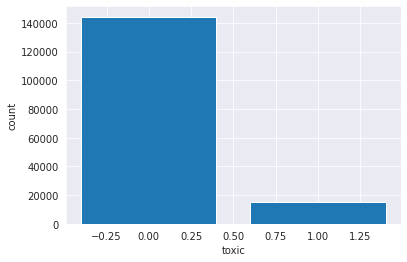

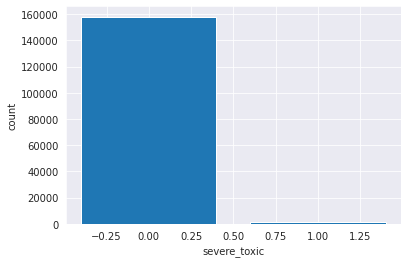

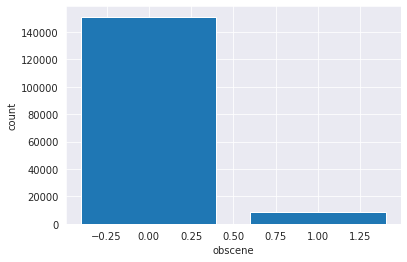

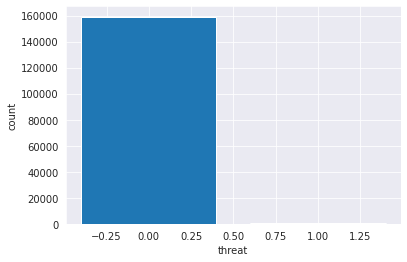

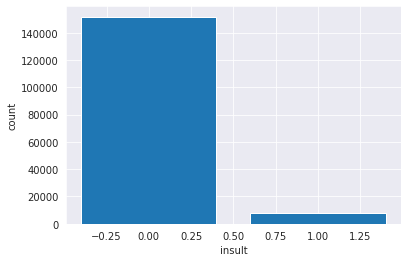

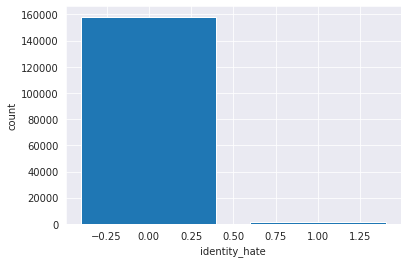

In [18]:
for col in label_col:
  plt.figure(figsize=(6,4))
  print(train_df[col].value_counts())
  plt.bar(train_df[col].value_counts().keys(),train_df[col].value_counts())
  plt.xlabel(col)
  plt.ylabel('count')

Here we can see the unbalance condition in the data. most of the comments are non toxic in nature.

<Figure size 432x288 with 0 Axes>

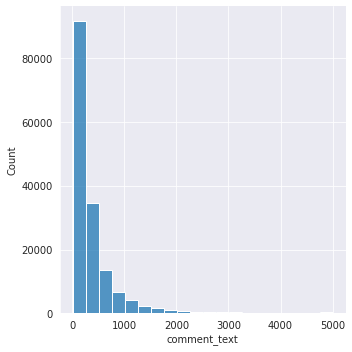

In [19]:
comment_len = train_df.comment_text.str.len()
plt.figure(figsize=(6,4))
sns.displot(comment_len, kde=False, bins =20);

About 1.4L comments are with less then 500 words and there are very few comments which are with 1000 and above words. 

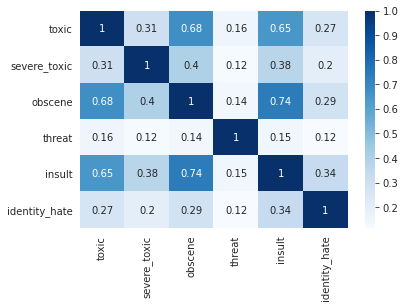

In [20]:
#correlation between labels
corr = train_df[label_col].corr()
sns.heatmap(corr, cmap='Blues',annot=True);

  We can observe the correlation between the target variables, `insult` and `obscene` are very highly corelated.

In [21]:
comments_train = train_df['comment_text'].values
target_classes = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
y_train = train_df[target_classes].values
comments_test = test_df['comment_text'].values

In [22]:
#preprocessing the text
max_features = 20000
max_text_len = 100
token = text.Tokenizer(num_words=max_features)
token.fit_on_texts(list(comments_train))
tokenised_train = token.texts_to_sequences(comments_train)
tokenised_test = token.texts_to_sequences(comments_test)
X_train = sequence.pad_sequences(tokenised_train, maxlen=max_text_len)
x_test = sequence.pad_sequences(tokenised_test, maxlen=max_text_len)


In [23]:
#model building
def text_classification_lstm():
  embed_size = 128
  input_model = Input(shape=(max_text_len, ))
  x = Embedding(max_features,embed_size)(input_model)
  x = Bidirectional(LSTM(50, return_sequences=True))(x)
  x = GlobalMaxPool1D()(x)
  x = Dropout(0.1)(x)
  x = Dense(50, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(6, activation="sigmoid")(x)
  model = Model(inputs=input_model, outputs=x)
  model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

  return model

In [24]:
model = text_classification_lstm()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 128)          2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 100)          71600     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)               

In [25]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early = EarlyStopping(monitor="val_loss", mode="min", patience=20)
model.fit(X_train, y_train, batch_size=32, epochs=2, validation_split=0.1, callbacks=early)

Epoch 1/2
4488/4488 [==============================] - 163s 36ms/step - loss: 0.0633 - accuracy: 0.9589 - val_loss: 0.0515 - val_accuracy: 0.9915
Epoch 2/2
4488/4488 [==============================] - 160s 36ms/step - loss: 0.0453 - accuracy: 0.9894 - val_loss: 0.0482 - val_accuracy: 0.9940


In [26]:
y_preds = model.predict(x_test)

In [27]:
y_preds

array([[9.9750501e-01, 2.9479098e-01, 9.6265090e-01, 6.7393966e-02,
        8.6340785e-01, 2.1393935e-01],
       [6.6555990e-04, 9.4991577e-08, 3.2546395e-05, 1.7111698e-07,
        1.9920943e-05, 2.3284344e-06],
       [1.9440982e-03, 1.1292665e-06, 1.7171180e-04, 2.4496562e-06,
        9.7315649e-05, 1.5297866e-05],
       ...,
       [2.4248449e-04, 2.7345838e-08, 1.3773203e-05, 2.4845491e-08,
        6.5124914e-06, 6.7195822e-07],
       [1.7496413e-02, 9.6148815e-06, 7.0311758e-04, 1.4884955e-05,
        9.6114055e-04, 1.8526423e-04],
       [9.8807317e-01, 1.3954830e-02, 8.4134489e-01, 2.7440183e-03,
        5.7486933e-01, 2.6718983e-02]], dtype=float32)

In [28]:
model.save('model.h5')

In [31]:
tf.keras.models.save_model(model,'toxic_model.hdf5')

In [ ]:
###end